In [68]:
import pandas as pd
import numpy as np
import os
import gget
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sys
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy

import utils as ut

In [54]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
]

print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = lf.drop_duplicates(subset='cellId')
    lf = lf[lf['cellType'].isin(macTypes)]
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    

    cellIds = lf['cellId'].to_list()
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    rf = rf[rf.index.isin(cellIds)]
    print(f"{key=} {lf.shape=} {rf.shape}")
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf

print('done')


ND...
key='ND' lf.shape=(536, 6) (534, 31053)
HFD8...
key='HFD8' lf.shape=(2909, 6) (2902, 31053)
HFD14...
key='HFD14' lf.shape=(4903, 6) (4893, 31053)
done


In [55]:
# merge all expression
rdf = []
for key in keys:
    rf = rna[key].copy()
    rf.index = rf.index + "_" + key
    rdf.append(rf)

rdf = pd.concat(rdf)
print(f"{rdf.shape=}")
rdf.head()

rdf.shape=(8329, 31053)


Unnamed: 0,XKR4,GM1992,GM37381,RP1,SOX17,GM37323,MRPL15,LYPLA1,GM37988,TCEA1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,VMN2R122,CAAA01147332.1
cellId,,,,,,,,,,,,,,,,,,,,,
AAAGAACGTCTACAGT.1_ND,0,0,0,0,0,0,0,0,0,365.898,...,0,0,0,0,0,0,365.898,365.898,0,0
AAAGAACTCCTCGCAT.1_ND,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1103.51,220.702,0,0
AAAGGGCGTTAGGGTG.1_ND,0,0,0,0,0,0,111.995,0,0,0,...,0,0,0,0,0,0,0,0,0,111.995
AACAAAGAGTATAGGT.1_ND,0,0,0,0,0,0,99.5322,0,0,0,...,0,0,0,0,0,0,0,99.5322,0,0
AACAAAGCACCGGCTA.1_ND,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,85.6971,0,0,0


In [56]:
""" Build the reference dataframe """
ref = []
for key in keys:
    lf = labels[key]
    ref.append(lf)

ref = pd.concat(ref, ignore_index=True)
ref = ref.rename(columns={'sampleInfo' : 'key'})
ref['id'] = ref['cellId'] + "_" + ref['key']
print(f"{ref.shape=}")
ref.head()

ref.shape=(8348, 7)


,cellId,cellType,key,x,y,colors,id
0,AAAGAACGTCTACAGT.1,Mac1,ND,3.089298,-1.726030,#fdbf6f,AAAGAACGTCTACAGT.1_ND
1,AAAGAACTCCTCGCAT.1,Mac1,ND,3.614130,-1.571004,#fdbf6f,AAAGAACTCCTCGCAT.1_ND
2,AAAGGGCGTTAGGGTG.1,Mac3,ND,3.086352,6.166065,#fdbf6f,AAAGGGCGTTAGGGTG.1_ND
3,AACAAAGAGTATAGGT.1,Monocytes,ND,3.178745,4.929769,#ffffbe,AACAAAGAGTATAGGT.1_ND
4,AACAAAGCACCGGCTA.1,Mac3,ND,4.344001,5.801922,#fdbf6f,AACAAAGCACCGGCTA.1_ND


# Jaitin-Style Plots

len(cid1)=1901 len(cid3)=2215 len(cid3)=2215
pdf.shape=(6160, 17)
CX3CR1 gVec.max()=4917.03 gVec.mean()=53.14 np.median(gVec)=0.00
THBS1 gVec.max()=11970.53 gVec.mean()=74.97 np.median(gVec)=0.00
LY6C2 gVec.max()=6630.82 gVec.mean()=49.81 np.median(gVec)=0.00
AXL gVec.max()=2915.45 gVec.mean()=161.33 np.median(gVec)=0.00
CCR2 gVec.max()=5405.41 gVec.mean()=270.24 np.median(gVec)=0.00
MS4A7 gVec.max()=5042.02 gVec.mean()=425.69 np.median(gVec)=189.43
LRP1 gVec.max()=4542.87 gVec.mean()=366.33 np.median(gVec)=304.84
APOE gVec.max()=90157.63 gVec.mean()=6431.54 np.median(gVec)=3595.83
LPL gVec.max()=17349.06 gVec.mean()=2282.00 np.median(gVec)=1867.05
APP gVec.max()=2301.50 gVec.mean()=211.02 np.median(gVec)=157.97
GPNMB gVec.max()=22551.09 gVec.mean()=1121.49 np.median(gVec)=233.62
LGALS3 gVec.max()=32948.93 gVec.mean()=5770.51 np.median(gVec)=4332.76
TREM2 gVec.max()=6085.19 gVec.mean()=1177.22 np.median(gVec)=1023.24
MMP12 gVec.max()=42173.11 gVec.mean()=898.12 np.median(gVec)=0.00
CTS

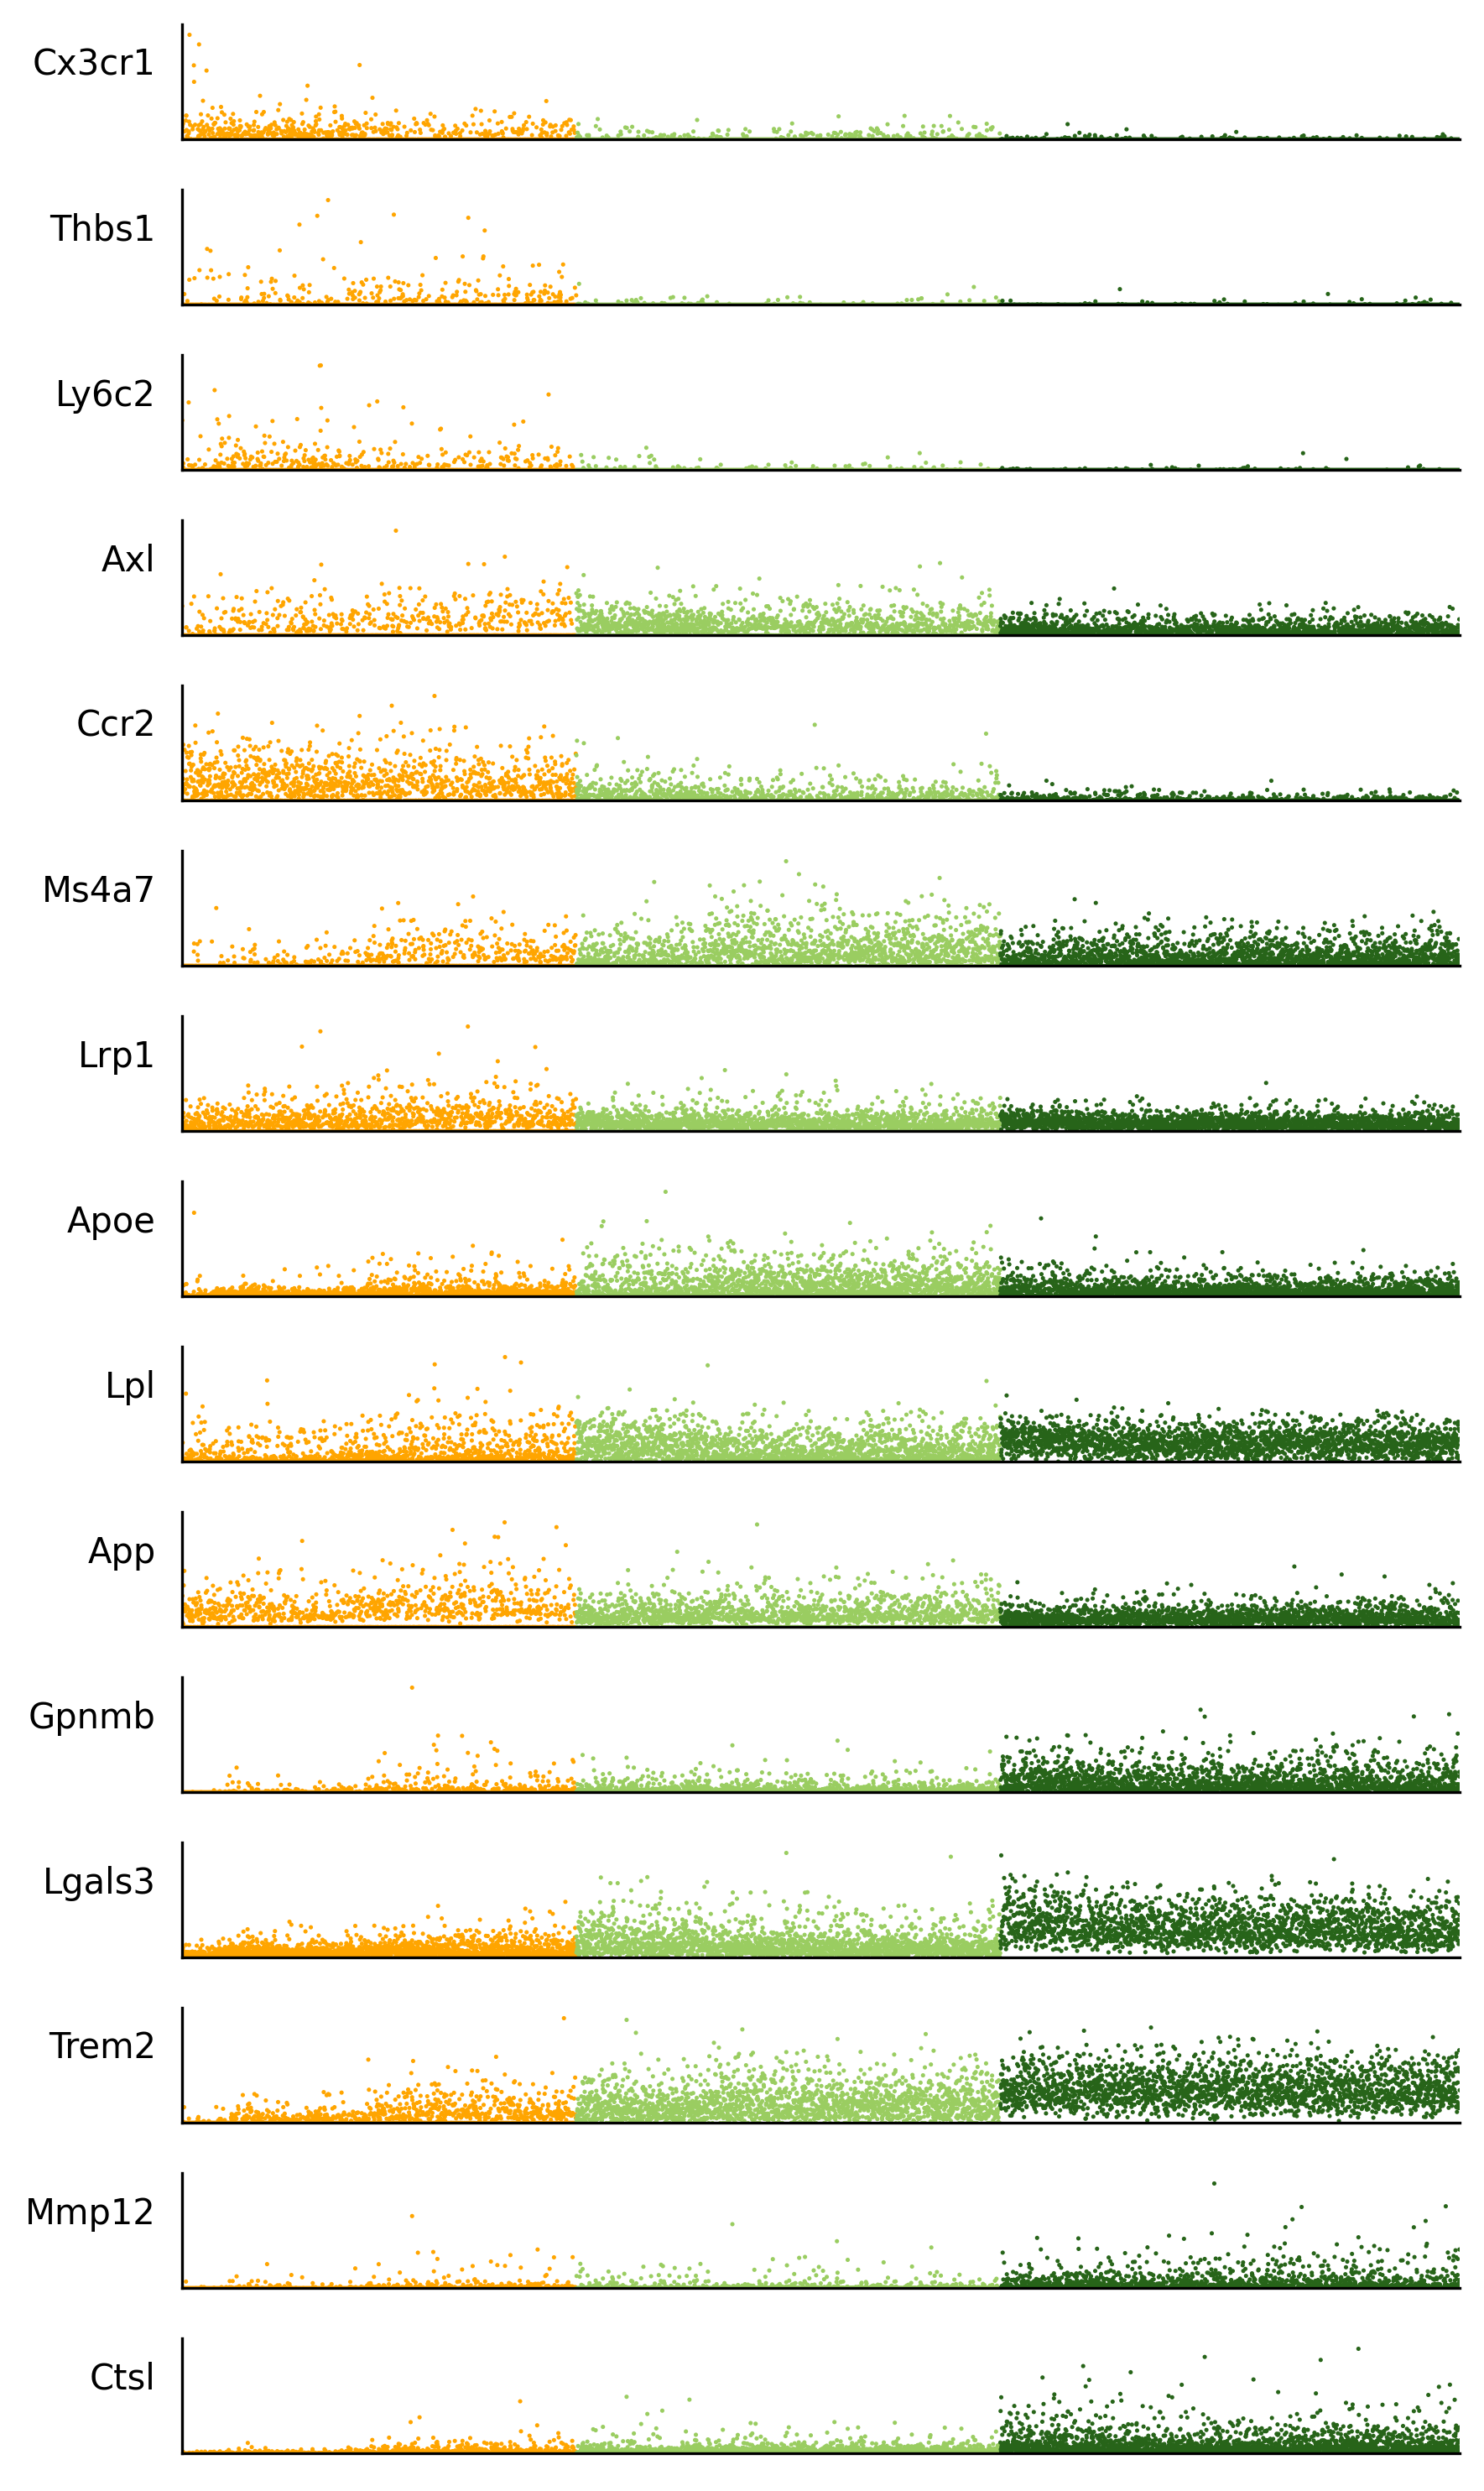

In [84]:
# get cell ids
cid1 = ref[ref['cellType'] == 'Monocytes']['id'].to_list()
cid2 = ref[ref['cellType'] == 'Mac4']['id'].to_list()
cid3 = ref[ref['cellType'] == 'Mac5']['id'].to_list()
cids = cid1 + cid2 + cid3

# type variables
c1 = ['orange'] * len(cid1)
c2 = ['#9acd61'] * len(cid2)
c3 = ['#276419'] * len(cid3)
colors = c1 + c2 + c3

# print(cid1[0])
# print(cid2[0])
# print(cids.index(cid2[0]))

print(f"{len(cid1)=} {len(cid3)=} {len(cid3)=}")

genes = [
    'cx3cr1',
    'THBS1',
    'Ly6c2',
    'Axl',
    "CCR2",
    "MS4A7",
    "Lrp1",
    "Apoe",
    "Lpl",
    "app",
    "gpnmb",
    'Lgals3',
    'Trem2',
    'MMp12',
    'ctsl',
]

genes = [x.upper() for x in genes]

pdf = rdf[rdf.index.isin(cids)]
pdf = pdf.reindex(cids) # sort the rna by the cell ids
pdf = pdf[genes]
pdf = pdf.fillna(0)
pdf['num'] = np.arange(len(pdf))
pdf['color'] = colors
print(f"{pdf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 10
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(len(genes), 1)
axs = axs.ravel()

for i, g in enumerate(genes):
    
    # gVec = np.log1p(pdf[g].astype(float).to_numpy())
    gVec = pdf[g].astype(float).to_numpy()
    print(f"{g} {gVec.max()=:.2f} {gVec.mean()=:.2f} {np.median(gVec)=:.2f}")
    gVec = sklearn.preprocessing.minmax_scale(gVec, feature_range=(0, 1))
    
    
#     axs[i].bar(pdf['num'], 
#                gVec, 
#                color=pdf['color'])
    
    axs[i].scatter(pdf['num'], 
           gVec, 
           color=pdf['color'],
           ec='None',
           # alpha=0.8,
           s=1.5)
    
    # axis formatting
    axs[i].set_xticks([])
    axs[i].set_ylabel(f"{g.lower().capitalize()}", 
                      rotation=0,
                      horizontalalignment='right')
    axs[i].set_xlabel("")
    axs[i].set_xlim([0, pdf['num'].max()])
    axs[i].set_ylim([0, 1.1])
    # axs[i].set_yticks([0, gVec.max()], [0, f"{gVec.max():.1f}"])
    axs[i].set_yticks([])
    

    
sns.despine()
plt.tight_layout()

In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Variable genes

In [ ]:
t = 0.0001
var = rdf.std(axis=0)
print(f"{var.shape=}")
print(var[np.isfinite(var)].describe())

genes = var[var > t]
print(f"{genes.shape=}")

In [ ]:
# get differential expression of the markers
deg = []

for mtype in sorted(ref['cellType'].unique()):
    print(f"working {mtype}...")
    cellIds = ref[ref['cellType'] == mtype]['id'].to_list()
    
    mask = rdf.index.isin(cellIds)
    inGroup = rdf[mask]
    outGroup = rdf[~mask]

    """DEG for highly variable genes"""
    for g in genes.index:
        score, pval = scipy.stats.ranksums(inGroup[g], outGroup[g],
                                           alternative='two-sided')

        lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)

        row = {
            'gene' : g,
            "cellType" : mtype,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'meanP1' : inGroup[g].mean(),
            'propP1' : inGroup[g].astype(bool).sum() / len(inGroup),
            'meanP2' : outGroup[g].mean(),
            'propP2' : outGroup[g].astype(bool).sum() / len(outGroup),
        }
        deg.append(row)
    
deg = pd.DataFrame(deg)
deg.head()

In [ ]:
alpha = 0.05
plotN = 15
prop = 0.5
ntests = len(deg) / len(macTypes)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 13
plt.rcParams['figure.facecolor'] = "w"


colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
]


fig, axs = plt.subplots(5, 1)
axs = axs.ravel()


for i, mtype in enumerate(deg['cellType'].unique()):
    
    # get significant DEGs
    mdf = deg[deg['cellType'] == mtype]
    mdf = mdf[mdf['pval'] < alphaHat]
    mdf = mdf[mdf['propP1'] > prop]
    print(f"{mtype=} {mdf.shape[0]=} (total DEGs) ")
    
    mdf = mdf.sort_values(by='log2foldchange', ascending=False)
    mdf = mdf.head(plotN*2)
    # mdf = pd.concat([mdf.head(plotN), mdf.tail(plotN)])
    
    mdf['geneName'] = mdf['gene'].apply(lambda x: str(x).lower().capitalize())
    
    sns.barplot(data=mdf, 
                y='log2foldchange',
                x='geneName',
                edgecolor='k',
                color=colors[i],
                ax=axs[i])
    
    # axs[i].set_title(mtype)
    axs[i].set_ylabel(mtype, rotation=0, labelpad=20)
    axs[i].yaxis.set_label_position("right")
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel("")
    
    
fig.supylabel("Fold Change (log2)", fontsize=13)
plt.tight_layout()
    
    